<a href="https://colab.research.google.com/github/k2m5t2/TapVirtualXbox/blob/master/Tap_Strap_as_Xbox_Controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tap Strap as Xbox Controller

Play a game with Tap Strap using Python.

In [14]:
from IPython.display import Image, YouTubeVideo

### Intro

[Virtual Gamepad Emulation Framework](https://github.com/ViGEm/ViGEmBus), or ViGEm, is a virtual hardware driver for Windows that fully reproduces signals generated by some widely available gamepads, namely the Xbox controller and Playstation's DualShock 4. The said input is controlled using a simple "feeder" program, and when combined with Tap's SDK, Tap becomes a shorthand Xbox controller (with limits to be discussed below). That's exciting!

### Overview

Normally, the usual constituents of such job would be:

- Designing interaction logic
- Sensor data processing
- Conversion into controller signals

For now, however, we can make use of Tap's built-in AirGesture recognition to skip the first two. Instead, we will be exploring the process of using Python with ViGEm, which is written in C++. This will pave us the way to use Python-based machine learning libraries in the future while letting us stick to lightweight code editors.

> Our immediate objective: Play a game with Tap Strap using Python.

My demo game of choice is For Honor—Ubisoft's modern take on the arcade fighting genre (containing the well-known Tekken series).

Preview:

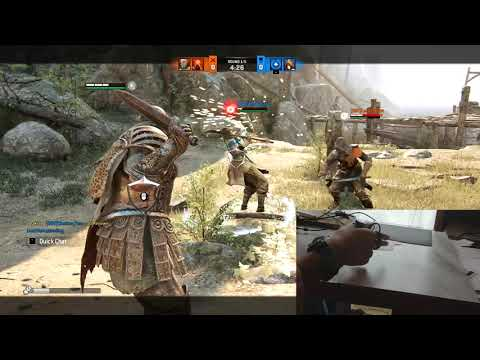

In [29]:
YouTubeVideo('knA5WmF07sk', width=800, height=450)

### Installation

Let's install the required libraries.

- Tap Python SDK

In [16]:
!git clone https://github.com/TapWithus/tap-python-sdk
!cd tap-python-sdk
!pip install .
# if running outside Jupyter notebook, delete the exclamation mark in front

Cloning into 'tap-python-sdk'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 276 (delta 130), reused 268 (delta 122), pack-reused 0
Receiving objects: 100% (276/276), 127.98 KiB | 10.67 MiB/s, done.
Resolving deltas: 100% (130/130), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


- ViGEm Bus

[This is the actual driver installed into Windows that will listen to feeder programs.](https://github.com/ViGEm/ViGEmBus/releases) 
Download the .exe installer from the link!

### Sidetalk: Tap SDK Tutorial

(Feel free to skip as desired)

Using Tap SDK is straightforward! A minimal understanding of 'callback' is required, however.

Let us first explore an example.

In [ ]:
from tapsdk import TapSDK

def connection(a, b, c):
    print("hello world")

strap = TapSDK()
strap.run()
strap.register_connection_events(connection)

while True:
    pass # this loop is to prevent the program shutting off!

If you have a Tap Strap lying around, try to run this cell. The moment your Strap connects to host computer via Bluetooth, Python console will shout *hello world*.

In the SDK, there are functions which start with `register_`, including:

- register_connection_events
- register_mouse_events
- register_air_gesture_events
- register_raw_data_events

As you can see from the example, these functions take **another function** as parameter—like `strap.register_connection_events(connection)`. You will also notice that each of these 'register' commands represent a specific action. Take a look at this diagram:

In [ ]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Callback-notitle.svg/512px-Callback-notitle.svg.png')

During operation, Tap Strap internally processes signal data to detect and notify motion events to the SDK. Anytime a motion event is invoked, the function registered to the corresponding event will be executed. This type of structure is referred to as 'callback', which you can [read more about here](https://developer.mozilla.org/en-US/docs/Glossary/Callback_function). [For detailed explanation about Tap SDK, read the documentation here.](https://github.com/TapWithUs/tap-python-sdk) 

### Sidetalk: Python and ViGEm

ViGEm library was originally meant to be used in Visual Studio ecosystem (with C/C++ or C# using the [ViGEm.NET](http://vigem.NET) SDK). We can use [ViGEm.NET](http://vigem.NET) with Tap .NET (C#) SDK (which the Tap Python SDK is based on), but we will miss out on Python's simplicity plus some amazing Python tools (like Jupyter!)

(The definition of term 'wrapper' is rather vague, but it generally refers to a program that provides an alternative method of running another program. In this case, we want to use ViGEm in Python.)

Since I had already wrote one with basic functionalities, you can download that and skip to next section. If you want to add features to the wrapper (like multiple controller instances—since Tap SDK also supports that!) or dig deeper into ViGEm, we can go through the process together. 

To do this, we will use ctypes, a package that lets Python interact with C programs. It even comes bundled with Python!

[This tutorial](https://realpython.com/python-bindings-overview/#ctypes) and [ctypes documentation](https://docs.python.org/3/library/ctypes.html) are good places to get a gist of how ctypes works. In short: 

- Loading DLLs and calling functions are straightforward: `CDLL().function_name()` (or `WinDLL()`)
- For each wrapped C function, the data types of arguments and returns must be specified, by setting `argtypes` and `restype` attributes to a ctypes data type
    - that includes: `c_bool`, `c_char`, `c_int`, `c_void_p` and more

Now, let's tackle the real question—what does a feeder application look like, and how do we write one?

Looking at the source code [here](https://github.com/ViGEm/ViGEmClient/blob/master/src/ViGEmClient.cpp) and an example feeder application [here](https://github.com/ViGEm/ViGEmBus/issues/10), we can infer the general workflow of using ViGEm.

1. Call `vigem_alloc()` and save it to a variable `x` of type `PVIGEM_CLIENT` (whatever that means)
2. Call `vigem_connect(x)` and check for errors
3. Call `vigem_target_x360_alloc()` and save it to variable `y` of type `PVIGEM_TARGET`
4. Call `vigem_target_add(x, y)` and check for errors
5. Initialize a `XUSB_REPORT` object `z`
6. Call `vigem_target_x360_update(x, y, z)` to push updates in controller values

More notes:

- 'alloc' refers to memory allocation. `x` probably would be an instance of some `vigem` class
- `vigem_connect(x)` probably connects the `vigem` object to ViGEm bus
- `y` would be an instance of some `xbox controller` class, and `vigem_target_add(x, y)` registers it to `vigem` object. (This step probably exists to support multiple concurrent connection of controllers)
- The `XUSB_REPORT` object has attributes such as `sThumbLX`, suggesting that it contains virtual controller's input values

The specifications of `XUSB_REPORT` is found at [ViGEmClient](https://github.com/ViGEm/ViGEmClient/blob/master/include/ViGEm/Common.h#L70) (starting at line 70). It has attributes `wButtons`, `bLeftTrigger`, `bRightTrigger`, `sThumbLX`, `sThumbLY`, `sThumbRX`, `sThumb`, which are all integer data types (short, unsigned short, byte). The buttons seem to have a binary representation, as enumerated in `XUSB_BUTTON` (line 47). 

As for the functions we saw earlier, they are described (not defined! [it seems to wrap yet another DLL](https://github.com/ViGEm/ViGEmClient/blob/465736429b8fe2b9d236b01ef0404f9bceb31106/include/ViGEm/Client.h#L39)) in [Cilent.h](https://github.com/ViGEm/ViGEmClient/blob/master/include/ViGEm/Client.h) Let's try to see what `argtypes` and `restype` they might have.

VIGEM_API PVIGEM_CLIENT vigem_alloc(void); // line 146

VIGEM_API VIGEM_ERROR vigem_connect(PVIGEM_CLIENT vigem); // line 173

VIGEM_API PVIGEM_TARGET vigem_target_x360_alloc(void); // line 200

VIGEM_API VIGEM_ERROR vigem_target_add(PVIGEM_CLIENT vigem, PVIGEM_TARGET target); // line 244

VIGEM_API VIGEM_ERROR vigem_target_x360_update(PVIGEM_CLIENT vigem, PVIGEM_TARGET target, XUSB_REPORT report); // line 413

These are right on point with what we've observed from the example feeder program. However, the presence of custom data types which are not part of [ctypes data types](https://docs.python.org/3/library/ctypes.html#fundamental-data-types) raises a question in terms of what we  

Upon research, I actually found a [working Python implementation](https://github.com/OzymandiasTheGreat/Joy2DroidX-server) of ViGEm wrapper. There, `c_void_p` was used for any non-standard data type. According to ctypes documentation, that represents `void *` type in C, a pointer without predefined data type. I certainly don't know what that means, but it seems to work—let's pass. 

It's worth mentioning that Joy2DroidX thankfully shed light on `XUSB_REPORT` class. Instead of being loaded from ViGEm, it was recreated in Python using ctype.Structure.

In [ ]:
import ctypes

class XUSB_REPORT(ctypes.Structure):
    _fields_ = (
        ('wButtons', ctypes.c_ushort), # max 65535
        ('bLeftTrigger', ctypes.c_byte), # max 127
        ('bRightTrigger', ctypes.c_byte),
        ('sThumbLX', ctypes.c_short), # min -32768 max 32767
        ('sThumbLY', ctypes.c_short),
        ('sThumbRX', ctypes.c_short),
        ('sThumbRY', ctypes.c_short),
    )
# credit to Ozymandias
# https://github.com/OzymandiasTheGreat/Joy2DroidX-server/blob/master/j2dx/win/ViGEm/client.py#L75
# comments mine

With that, we can write a working wrapper. Let's import ctypes:

In [ ]:
import ctypes
import time # plus time. hehe

Next, we load the DLL and its functions then specify their `argtypes` and `restype`. That's the end of ctypes for this program!

In [ ]:
# if you are running this in Jupyter, make sure XUSB_REPORT cell has run!
# if you're writing into a .py file, add XUSB_REPORT class

vigem = ctypes.WinDLL('ViGEmClient.dll')

connect = vigem.vigem_connect
connect.argtypes = (ctypes.c_void_p,)
connect.restype = ctypes.c_uint

alloc = vigem.vigem_alloc
alloc.argtypes = ()
alloc.restype = ctypes.c_void_p

target_x360_alloc = vigem.vigem_target_x360_alloc
target_x360_alloc.argtypes = ()
target_x360_alloc.restype = ctypes.c_void_p

target_add = vigem.vigem_target_add
target_add.argtypes = (ctypes.c_void_p, ctypes.c_void_p)
target_add.restype = ctypes.c_uint

target_x360_update = vigem.vigem_target_x360_update
target_x360_update.argtypes = (ctypes.c_void_p, ctypes.c_void_p, XUSB_REPORT)
target_x360_update.restype = ctypes.c_uint

Like the C++ example, we create a ViGEm instance and connect to bus. Let's do the same for controller.

In [ ]:
bus = alloc()
connect(bus)
controller = target_x360_alloc()
target_add(bus, controller)

These so-called dictionaries will store each button's binary value for calculating `wButtons` and attribute names of analog input, as well as the maximum value. The many `None`s are placeholders for an attribute called `lifetime`—it will act as a timed on/off switch, with `None` meaning 'off'.

In [ ]:
buttons = {
    'dpad_up':         [1, None],
    'dpad_down':       [2, None],
    'dpad_left':       [4, None],
    'dpad_right':      [8, None],
    'start':          [16, None],
    'back':           [32, None],
    'left_stick':     [64, None],
    'right_stick':   [128, None],
    'left_bumper':   [256, None],
    'right_bumper':  [512, None],
    'xbox':         [1024, None],
    'unknown':      [2048, None],
    'A':            [4096, None],
    'B':            [8192, None],
    'X':           [16384, None],
    'Y':           [32768, None]}

axes = {
    'left_trigger':   ['bLeftTrigger', None, 127],
    'right_trigger': ['bRightTrigger', None, 127],
    'left_stick_x':     ['sThumbLX', None, 32767],
    'left_stick_y':     ['sThumbLY', None, 32767],
    'right_stick_x':    ['sThumbRX', None, 32767],
    'right_stick_y':    ['sThumbRY', None, 32767]}

status = XUSB_REPORT()

This is how long a `Press` will last, as well as how long it can stay on (Note: you can overwrite these during function calls)

In [ ]:
DEFAULT_PRESS_TIME = 0.1 # seconds
MAX_PRESS_TIME = 30 # seconds

These functions calculate the value of `wButtons` and push updated controller status to ViGEm bus.

In [ ]:
def evaluate_buttons():
    b = 0 # binary sum
    for key in buttons:
        if buttons[key][1]:
            b += buttons[key][0]
    status.wButtons = b

def update():
    evaluate_buttons()
    target_x360_update(bus, controller, status)

`buttons` dictionary 안 None의 자리에 수명을 저장하는것으로, `evaluate_buttons()`는 버튼이 켜진것으로 인식한다. buttonDown()은 MAX_PRESS_TIME을 이용한 buttonPress() call에 지나지 않는다.

By replacing `None` with a time, the button is considered 'on' by `evaluate_buttons()`.  `buttonDown()` is a `buttonPress()` call specifying duration as MAX_PRESS_TIME.

In [ ]:
def buttonPress(button, duration=DEFAULT_PRESS_TIME):
    buttons[button][1] = time.time() + duration
    update()

def buttonDown(button):
    buttonPress(button=button, duration=MAX_PRESS_TIME)

def buttonUp(button):
    buttons[button][1] = None
    update()

This is very much the same, except that analog values are added.

In [ ]:
def axisPress(axis, value=1, duration=DEFAULT_PRESS_TIME):
    axes[axis][1] = time.time() + duration
    binary_value = round(value * axes[axis][1])
    setattr(status, axes[axis][0], binary_value) # dealing with analog component
    update()

def axisSet(axis, value=1):
    axisPress(axis=axis, value=value, duration=MAX_PRESS_TIME)

def axisOff(axis):
    axes[axis][1] = None
    setattr(status, axes[axis][0], 0) # dealing with analog component
    update()

When an input's lifetime is up, `buttonUp` or `axisUp` is automatically called.

In [ ]:
def lifetime_handler():
    for key in buttons:
        if buttons[key][1] and buttons[key][1] <= time.time(): buttonUp(button=key)
    for key in axes:
        if axes[key][2] and axes[key][2] <= time.time(): axisOff(key)

### Testing ViGEm

If you are following this outside a Jupyter Notebook, you can download `vigem_py` wrapper here.

You can monitor the controller status inside your browser [here](https://gamepad-tester.com/).

I added some small details in the wrapper:

- Analog input now takes float point value between 0.0 to 1.0 instead of binary values
- Every invoked input has an attribute called `lifetime`
- Correspondingly, all inputs are based on `...Press()`, which will both turn 'on' and 'off' an input.
- For inputs to work properly, `lifetime_handler()` must be ran repeatedly (inside a main loop).

This was mainly to make multiple simultaneous use of inputs easier. I think it works well.

A helpful friend to run `lifetime_handler()` for 5 seconds:

In [ ]:
def test(length=5):
    end_time = time.time() + length + 0.5
    while time.time() < end_time:
        lifetime_handler()
        time.sleep(0.15)

Press a button for specified amount of time with `buttonPress()`. Required argument: `button`; optional argument: `duration`. Default is 0.2 seconds

In [ ]:
buttonPress(button='A')
buttonPress(button='X', duration=5)
test()

Assign a value to an axis for a specified amount of time with `axisPress()`. An optional argument, `value`, was added. Default is 1.0

In [ ]:
axisPress(axis='left_stick_x')
axisPress(axis='right_stick_y', value=0.5, duration=5)
test()

`buttonDown()` and `axisDown()` invokes and holds an input. You can stop it using `buttonUp()` or `axisUp()`. Alternatively, it will automatically turn off after MAX_PRESS_TIME (default 20 seconds).

(To keep an input for really really long, you can specify the duration yourself. Let's say... 1 year?)

In [ ]:
buttonDown(button='A')
axisDown(axis='right_trigger', value=0.75)
test(length=10)

In [ ]:
Image('https://media2.giphy.com/media/ekS3TiNU13IMKnSuD2/giphy.gif')

The difference between buttons and axes are whether they are digital or analog (i.e. bumper is button, trigger is axis).

All buttons and axes listed:

| button      |              |            |             |
|:------------|--------------|------------|-------------|
| dpad_up     | dpad_down    | dpad_left  | dpad_right  |
| start       | back         | left_stick | right_stick |
| left_bumper | right_bumper | xbox       | unknown     |
| A           | B            | X          | Y           |

| axis         |               |               |               |
|:-------------|---------------|---------------|---------------|
| left_trigger | right_trigger |               |               |
| left_stick_x | left_stick_y  | right_stick_x | right_stick_y |

### Interaction Logic

AirGesture gives us ten possible inputs to use: up, down, left, right sweep using one finger, the four directions again using two fingers, plus index-to-thumb and middle-to-thumb pinch. A similar AirMouse function is also available and gives a two-dimensional analog input based on where you are pointing. 

Of course, this is not quite enough to fully emulate an Xbox controller with 2 analog joysticks, 2 triggers, and 10 buttons. Therefore, we have to come up with some sort of smart logic to make it work well within the game. 

Something really useful is to draw out all of the possible actions in a flowchart.

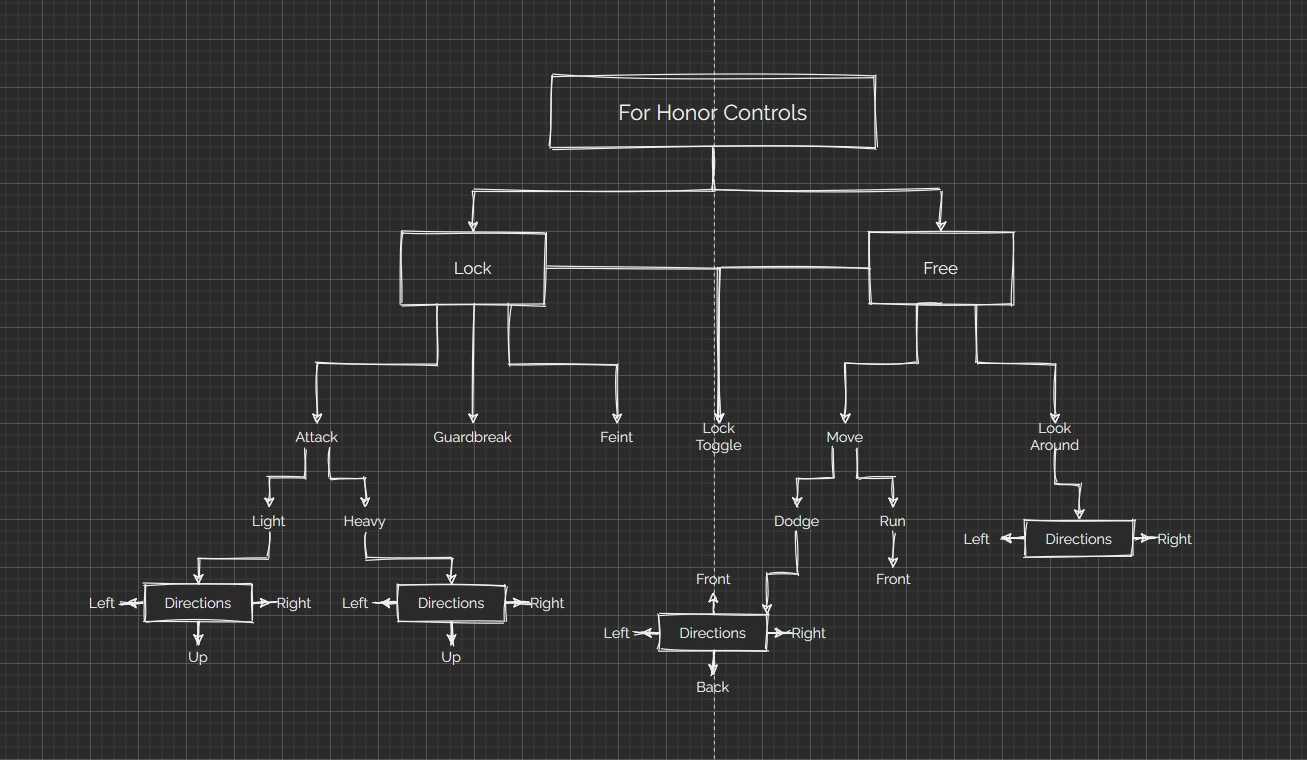

In [32]:
Image('https://lh3.googleusercontent.com/hiY2POUA7eMymTfzUJv9Dq6jc3-85BBp32V_oiitOp532elt2oN6KUN99LeRqS2JYJzrlJLWZM9slUmlrZtQXHnze0f2lIIb8fxrqiEVuNuGqgRAUTIi8TTuN6f3qdykLhzK3JNLddYFZn1n8Z3hanlScek8vBchAnZnR2n4ewBJQyaviT8fAW-dYEjyt3xQ3Ms6RHg_N2GkSU2j9okQPb-YJXerDWnJcJNSe6hMM98E8XwXsb9IErcnBh9gikeH5-oal4hC-f-NkA01jrXNUyB4wqLRLSS0NA9U1CEJYnvKB0PnrR-FiDiKyIjZtxCk1MkRG8OK0wIyT63IRsFljj3yoiz0Iizh3EySbhUZ5WZfeoPZXAE39RPEw1ecjnLA5uWLJZ8n9UGxHNR_3_lMAqS5riAnTwKUi_Wd41Uvh6wTFDbiaj-XlF9IDcqO00MJp6DjBFnWNAWyyHVtFPsaTBZJnXOKuWgprQZiSBbWzRnyxcEg8T7lifopclxh5sGR1rLHNQeAByVFlNiAoQYgEBghbdi_1GIUVQrsciS_YVNrLUgBBnNzfT-ppsdDKDVO-E0Ar_hzm4hWqWXilJMffC83BbsryTidosnPNptru4vQDdEEHXW2XBY-OfjEGsU5bXtvnA_viPbmmEMVZAfyG-CL9_zu4ypsxUKI-d1wYbd6t_5IQ4UQqPy7hJJY5g=w1307-h760-no?authuser=0.png', width=800)

Naturally, Tap's AirGestures input will look like this:

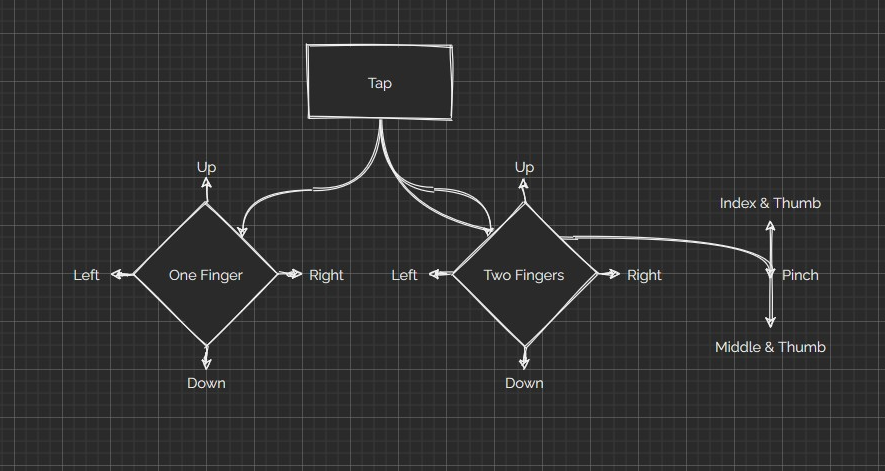

In [31]:
Image('https://lh3.googleusercontent.com/Sc_Jf2vqSZt-O1eWIkx0TnXQvRYF5jDUv27vSBxdMwbtbx0G6blnXAD0XCt30Zno-xXsLr2nvesTLkUDYTO_lnKOMz6zP8cQqwFCqEo7PPxkK9N_xWxsi6oQLkhyBGBVjb6ke_HwWbSPKb3jtvh7-A2alVSnXgOGBji89DRuPh-qJ5_hpl4nT0Pury2Adfn4DOaB5Oazb-2z_uJt3u1Pp-Ba0kjYa3lFoUrOPTkyv_KBN9OCoxLQ3pbpLotoM0fWMdxvLr5qE0ozencLXkAvkRsE0tFxdNSb9W3NIk0zPvz0rum5GzYlkrdiGiAfNJwxxaI-2YvaG1W4Di0BiXC634Jcy8PhKEaXWd0860gzCHojFBcowHfZN36_DrYu4rVI2GjQccqfu60OUGogNkEfC3gZcafXnFg9JBgDHL6DPA5G2bK-EipICLQeGxAY5Xjyqe1brKCgGhd_elk4bjLznjqttMAvPdbQYd0T_kjnJRRp49IHzVfsZTZA2VxfM4Simxg4LPfjZzqoHF4z1_C5pXMn8l1xnZ7iTBs61s_0XuHQ8LQCQM-ZpN-5qv3uruWqKuCj53jPAtC9DGIqLrFkvz8IRrx1_NLszB_knUy36n59i9ICqWztaY4pQ915eWdJGtQwzXNJJqshmKSBtVGFaBhFQoPF6NOD63mwk0NVo5y-g_04YuKXSjOQ6__DlA=w885-h471-no?authuser=0.png')

Then, we can start modifying either of the two in order to make them match.

In [ ]:
Image('https://lh3.googleusercontent.com/U6INCLLxp6t5FLY1yKGeC4phzIZexwKCUdigrU2LLuvzhDXX79lqibt954NB9u8BBzQbjJB24DeVJ2Vu_OxTLvUAiZs594q8U0vYSD8ZXhKyJKb3JIKQCed6-lU_26g5SQrAsCbDeJTi8prilmUgrTmb-qK8JUiaXMvRK83wCGKR3ws9pv8hIF4ofjptlqMNn3ff-SG7wa5znimJvkFgjJFUdlTgCfpv1tFJFdw-ayte-ulTbnETZR8J8EMCyBEBwHDQqvuVLD2ZKGyyfbEcmaC1HzMMpfi6bOEyPcal5qH9j1Kv0bQyBGe83QvLlwDekitQOlzA-dUFmAUaqYUATNzpbm-QZ9JaqvzquWh_z7pH2Ht5HfXbPdtsYXkqiOc_JQ-LWvV1wURPYLU5g-oCQUWsgtlJF6VkJKJc0MKF5r427mOIylUbxK9mW1vqkXaFt964i2FqcLo25YeY8aHeb9pA7elghiSqFmDlJe2QCRxfIRuiYR2gbwFJjM-wEgG7TieXJrcjxq-nX_UOfOoVZYn6rOHkIgW4EWVjkZDVxMUZDOYsoq2VcVgI-yM3CvaKtfPmmGQQ1vtq0fx_orNMvaICjuB9QflCqKWvG_qiFEDTLYyJxdj_cD7VfedqSpf7ov8Gps6TyvONrih2yUhMlS1wxg0R8OOft8hiD1J0kkIMg_BdvPc9N8EzhwtQhQ=w795-h892-no?authuser=0.png')

In For Honor, attacks are directional—coming from either left, right, or up. Normally, this would mean that we need to allocate three inputs for each attack, leaving us with little room for everything else. But because the game automatically locks the camera onto the enemy during battles, we can let one-fingered sweep trigger both attacking and looking around that direction without noticeable effect during battles. When outside of battles, the user can still look around, perhaps in a slightly inconvenient way.

Another tool is to make some infrequently used inputs as special keys—here, the subsequent sweep after one-finger downwards will make the character move to that direction.

In [ ]:
Image('https://lh3.googleusercontent.com/2HyYfYSYkaBYrVBHAByK_6zMOZNB1b_bJs0aP0RC6eLrWEeRFN6pEj-dGIGYXDcDARw4kgBYQThcLicYmSeC5mq_x9qS_Mcl2gc-pNfW8DfqVrVnLX9_aYYBikdBnnk8wcz_TTyho3e0QB5zOwmw-FVA0vhDMvnU-eHcKIp-GrCbtJ8qbeseuOZA6n6HclSmEK9nbcclU7sr6G-oNMa2D08BIoWoQ91j1sEBR1iSLIGl5HEWJQY5yfQgPMFxhpHWq-fOuxqQnoReggcURFmrk93lr9CrDByGjRGkh2lNtCjoufMs17EBOvJ-brIyVRxzInEPi3Qn5IPu547pr61WHn7Q1jZZRH-OkH8HQa3QVgc6bsa7G8FhYuQ98J1iQF_GUSU5aYgTsFn3evB5RpnsB6GcegFlMnvdtvP_CsplV0Ggi4zqLKqwUkwWL8VIUdrPOO8lyi9_OKPV8UuUdSFG2CZo_rehAOYzqFXt6-_xmzTFjSudnPVDhBMyqzGaYaugZvjoG6IUNaGGLF4_M30-AC0zpicni_4dRkTwLT9a6gv8-kzHx2z0-QrfNrYvB9skvZ2ZlGIgJ6rQvztLzHhdR3ObwlN5xRmF8K3OAB-Prc7zVPloQ0lJi1Au8d8QqpGv_w04j-ASHxqxWidXak7cidysy2lIi_L1NDfaRgZoOE8R6ipEJ6Y_8jwS9TXE2A=w868-h882-no?authuser=0.png')

Then, everything else was straightforward. Here is the final, merged map.

### Coding

In [ ]:
# if in Jupyter, make sure that previous cells have run!
# if writing in a new file, include import vigem_py

from tapsdk import TapSDK
from tapsdk.models import AirGestures

strap = TapSDK()

`connected` will simply be used to turn off the program once Tap disconnects.

In [ ]:
connected = False

def connection(identifier, name, fw):
    global connected
    connected = True


def disconnection(identifier):
    global connected
    connected = False

TapSDK provides us an integer to determine which gesture has been made. Now, we can compare the gesture integer to `dc.UP_ONE_FINGER` and `dc.LEFT_TWO_FINGERS` instead of `0` and `7`.

In [ ]:
class decoder():
    NONE                = 0
    GENERAL             = 1
    UP_ONE_FINGER       = 2
    UP_TWO_FINGERS      = 3
    DOWN_ONE_FINGER     = 4
    DOWN_TWO_FINGERS    = 5
    LEFT_ONE_FINGER	    = 6
    LEFT_TWO_FINGERS    = 7
    RIGHT_ONE_FINGER    = 8
    RIGHT_TWO_FINGERS   = 9
    THUMB_FINGER        = 12
    THUMB_MIDDLE        = 14

dc = decoder()

These if statements are very much self-similar, but I haven't yet figured out a simpler way.

In [ ]:
moveState = False

def airgesture(identifier, gesture):
    global moveState
    if not moveState:
        # light attack (top)
        if gesture == dc.UP_ONE_FINGER:
            axisPress(axis='right_stick_y', value=0.5, duration=1)
            buttonPress(button='right_bumper')

        # go into movement mode
        elif gesture == dc.DOWN_ONE_FINGER:
            moveState = True
            strap.send_vibration_sequence(haptics=[100,500,100,500,100,500,100,500,100], identifier=identifier)

        # light attack (left)
        elif gesture == dc.LEFT_ONE_FINGER:
            axisPress(axis='right_stick_x', value=-1, duration=0.3)
            buttonPress(button='right_bumper')

        # light attack (right)
        elif gesture == dc.RIGHT_ONE_FINGER:
            axisPress(axis='right_stick_x', value=1, duration=0.3)
            buttonPress(button='right_bumper')

	      # heavy attack (up)
        elif gesture == dc.UP_TWO_FINGERS:
            axisPress(axis='right_stick_y', value=0.5, duration=1)
            axisPress(axis='right_trigger')

        # guardbreak
        elif gesture == dc.DOWN_TWO_FINGERS:
            buttonPress(button='B')

        # heavy attack (left)
        elif gesture == dc.LEFT_TWO_FINGERS:
            axisPress(axis='right_stick_x', value=-1, duration=0.6)
            axisPress(axis='right_trigger')

        # heavy attack (right)
        elif gesture == dc.RIGHT_TWO_FINGERS:
            axisPress(axis='right_stick_x', value=1, duration=0.6)
            axisPress(axis='right_trigger')

        # lock-on
        elif gesture == dc.THUMB_MIDDLE:
            axisPress(axis='left_trigger')
        # feint
        elif gesture == dc.THUMB_FINGER:
            buttonPress(button='Y')    

    # movement mode
    elif moveState:
        moveState = False # untoggle movement mode
        # move forward
        if gesture == dc.UP_ONE_FINGER:
            axisSet(axis='left_stick_y', value=1)
        # move backward
        elif gesture == dc.DOWN_ONE_FINGER:
            axisSet(axis='left_stick_y', value=-1)
        # move left
        elif gesture == dc.LEFT_ONE_FINGER:
            axisSet(axis='left_stick_x', value=-1)
        # move right
        elif gesture == dc.RIGHT_ONE_FINGER:
            axisSet(axis='left_stick_x', value=1)

        # dodge forward
        elif gesture == dc.UP_TWO_FINGERS:
            axisPress(axis='left_stick_y', value=1, duration=0.5)
            buttonPress(button='A')
        # dodge backward
        elif gesture == dc.DOWN_TWO_FINGERS:
            axisPress(axis='left_stick_y', value=-1, duration=0.5)
            buttonPress(button='A')
        # dodge left
        elif gesture == dc.LEFT_TWO_FINGERS:
            axisPress(axis='left_stick_x', value=-1, duration=0.5)
            buttonPress(button='A')
        # dodge right
        elif gesture == dc.RIGHT_TWO_FINGERS:
            axisPress(axis='left_stick_x', value=1, duration=0.5)
            buttonPress(button='A')

Then, we register all of the functions and put `lifetime_handler()` in a loop.

In [ ]:
def initialize():
    strap.run()
    strap.register_connection_events(connection)
    strap.register_disconnection_events(disconnection)
    strap.register_air_gesture_events(airgesture)


def main():
    global connected
    initialize()

    while not connected:
        print('waiting for Tap...')
        time.sleep(3)

    while connected:
        lifetime_handler()
        time.sleep(0.015)

    print('closing')

In [ ]:
main()

### Results

- Move & dodge

In [18]:
Image('https://lh3.googleusercontent.com/Ty6wUSXV_CMWswG9c6oPfzxaIOfznZB6b3F5hUrDjy5DS5PGUfQcDGb1T9y_3Tzapa5fHYCrEoR-6rwvXz5zLoC-P7_hZiByAodeMj7va2zOxaf1BUZ5CenIlEicYJHrAQRzapPosYQXcElHrxKhXWDlfvhUmAAO6uowZ-ATrdOfDtAHveoO4BXCQ_8yNRpAVIKBhwIRp04aOkjpYuE-Vb9enCHzhGevtS9TU59BYRsUqs1kHs3qaF9sBOaYWwf2XRT6OUdfCW1osML6q-2ZnjjPg1EAVehtiqLb1UKDeR_N2GY89mP5w40gyZNF5bd8apmBxPtZA21__vofpgfijNeKEKtggkDtp4cKY_7A-v1F0AY8-QTkGVSxg66-pmEoEh_VmEALbZIFqRMks4kHy-GFa2JklMuFT8SYEq5A5_OivmXflPbkm4Jb9qS92qDLxJOdXs6kLk7JoWYDtXpNeb-2fio-6MeuJclCewCVkSEcudLje9bKesSFGBu71kjdCLaRHrPwk78PL_9xbii7WmdTbnOJPz0enJfTZ2fltSyY1xX0cR0zzyN70qMMfom5G1L6pXmcUFIwhCvgJiDag-nnNza0cjQte1aFkspBwaSvUuuhvLfPzIQli3iMPwE8A71mXdgjL2TtShruaVZHtnjppB5SYXVA4glfic_BxJ6Lb3qoLVTsnK2DMT0z_g=w480-h270-no?authuser=0.gif', embed=False)

- Look around

In [19]:
Image('https://lh3.googleusercontent.com/lhBdQ4QcaFFx37oRftumVrBSrpCOwS6IKGE2gCNn4n0-9NOoiSPJmcoGMkTzjcIsauuyZSkTcCsnM07mCSi8sZLAhldB8ghZaGntOTXer7_YSv4lOCZcDEAnZ4j5Yj_84snkhnSud6dhFR9L-AFRtJivxG6ohoH5yU4Uf7jX12xogTNqpveb36EMdukVyzZLfoN1xaATYV1iABoYL4N4FQ7N-d2_2fQ7hY9ph3SxEW5ptx4Cw3k-5o4pGVsCsnneT-kPBv0FedDOFYmCp4X0WAVpFSUfYF7_kTZvRjjVBxse0fCxbW3nfXlDcHPna4YGv1yfNft2EZF6DqAsP-Dh-fo5cZoDz6sPb-4g3w4ESQ8MyJsdNOFzKeJdsSqI5mDtod7BSOM2wlTY7FOB01FZapLhIBQv3B_HslBjyFbJsGiHD41eswquOOcAqNyAp5jClzgrayD3RPs99-ZSEHsZqwvl_aaSiyuvC8wHB1kFNHHTLdjzIPvcBBCY-xebGyfzph2sahUBzdNJX_MBt5aL06TSakyltDiDOWuKe4GLsbxOfGuCNoU7qwZOVlpqY6n43AbF5RfKdKZqlU1evX5evnQTjl_6X-tcEQ1kqMPRTcDRVxAKQHwfuDvQjy68F7dRBJdNAM_cnR16rBHvr7ujVLEfS__OrXZtjE2m4pfmfkcUzkYAABjVe8VS6n13iQ=w480-h270-no?authuser=0.gif', embed=False)

- Attack (light)

In [20]:
Image('https://lh3.googleusercontent.com/1872LgN2xsY2rVRlV-baRjrldHX5oSFTgskGi8PdYuc25ezVVXe8LGhblCzHf-JW7fsdchPgbL_mx_sncH-pKc7ffGK7Ddjyp6EZEGwhdeD9nfggQXdYaesw8SAORgJJk4O5SGEKLOludM2wdr73X4boba8ldd9oDcYIX7aNOiAhy6ZVPBcQ2wWMc1gi2PNx6NUWxTtW8LDBKkTY0gj9T66dWGzTRDdB9vFKKH887YZc-9RIIJV9OGLoWZgtZq8bHD7ZvMLfiwq8dxPGO88K9eDrRJ1ZTnxAvDrcR_9V2dgDpH0dBP9wmD8QXbuHuPiqIA5umw-9oPsybrJoys4T4Qywhlwkvuf6e2zrCKPeIDGNDz75gQmD4DVBtIW_Bv_w2byM1_Psad6jxqAvY4lYveygW8GkyoOH8mMkfNZ8OHpzo_vdNAHZsCwhNtPIL4HbttKPKJXMgdDZh-0JYk0lhCzClbC6b9sYtEf6UwNzpr2uwNam-mRCFhdDPJ7tbsU_APoWsUx9YYfoARY6kCLinW_Xd4VSe1qnVM4XEvZuZ--FTU1XU8FOVAUAAyGgHWoU275aTLKPq4Ke4MUXwLrMvkdUGDVwlVLNTfW6w3qoT4biZZvD-j_QgIvp4KUG28XP8eB0kZldg2kbuqEzbCt67KeolhWMmMcs2TZWBCXVsGuIJvie5FJn2W6zy6fgvQ=w480-h270-no?authuser=0.gif', embed=False)

- Attack (heavy)

In [21]:
Image('https://lh3.googleusercontent.com/PFyp0zh0DXRfO2m9O0MA9KlE-sEik0bcqpPHwBTPdlqeg-w4g6Ll1GYIQ1Th0UZRvfSHHoe66CZxNlFkhT_ylPeGnZRkLADVAlibYsHiL72O2u2Q_5bci3OEFLJl2fvNjR08-BRuZFa6hMf5WanFksBZBeAUKZ-9SY3ia6fMRMHmArOvQh1lDXNNEO6J-xjtqmKd-OOxKpcO6Rnm5MeDJ_5Xri1lxMvuG5BCae3_qY0V_6hzBpJ2ypbLKUVJpi2S1CaRne7FFKApdwewcwgUyAJzoBYpG7SOVYe99cZCp34fRnEgVqQnkKQKp2PxTtg3yfPtEHKC5RWHZhcpmV3L4BaxRilkV1vEI7IFUENvxQ7FJ21G4DINk2ON6bDcUvDa4_9jqVrSMGjG_2fOX3Koa7Ge1AglnjLaSKXqRaS0yuY_FJ3Jj7WNpeUYpZnyG7Xo2awvxbekBdk3rhZb4tkgMY4jfU4SMc56TdyIvI15gVVDqvs5baSG_LByepU_WJ2DSg-QqDHUc1yD_93RTomfb1KX7cjfUZWFM0WGijJZ8s1FS45PRdJYIVlICXTAQhTIR_aDcYz3vUz7vMPMdXQnKR4uEDWMqsxBufRJLjIhwOkeL1Tnv8mEkfsDJfDbofhm_4VcfJIA52I59JnBLTJuYdTtldQlNjPQ8kSa2AukGzhzjs-QLvSOsHPmwNdNVg=w480-h270-no?authuser=0.gif', embed=False)

- Guardbreak

In [22]:
Image('https://lh3.googleusercontent.com/wygCSWaStSY3KDlkIwJzcM_9BzVR6USZ7-0cDkfR3YkVOn7_Q_5Fc0SF1An12PFFnT01ctfTc2Lf4RC813SJKL3bU_JQW5xiSd9jAtsWd09ILP6uXUrMRudLPmpFJdEkybXOvKlVJgi2R-sSwoDp6XDbfeFEK6nN178IzaUAa-9AjjU2fH_hW3nhcVNuD3qq_astJNgOIp9-WyXFJFOirKla4xKz89KAtIfWzpaQDiGP0Ed9P9ZSdcWgsmj3min7vDlTEkJNbrz8MXe-1Kn0eanv665LCccoq5kLPX9mP_e8xf8E9NxCJFOdaNwxrseDqgWv_HrjS4BBM5rD2jKOdVOgzVaHkzuDVfNZAFUrHpY83t7v9rHUuLhw7qSlD9D8jOkKZOFV_7yoL_5vaat5L5hqEPD-TaDsS7kzbB0b3MHOSpfriLHKVW2dl3XCaNAX3nx0M8HOv2nOkRIgikKZtSuAqZGVusChfhtPFMPFz3beVqQUaCv44bgu-yV77e9iYfQq0Gzwo8mw5RL7SEGv52f-udYrtAX5tbhuUDRYYiQkYHBC0ZuyiwiDILbM2vCdjJNPj4c6bfnyS1MFDKtflMyjxyutIR7ric9xr11nQKES8szBuvRsJichcv0mlscMROcvBeSFlYpNywPdRp70yZH8Eb2LW5_vjP-2DIKj8361Ippo2Zr-iCXDXdJyog=w480-h270-no?authuser=0.gif', embed=False)

- Feint

In [23]:
Image('https://lh3.googleusercontent.com/CV9a9cVlmi6Y1ehN472MWOCpD5E_McCbJ0wb1yebvLhjep8gdehRzUQSdp8axR6NVeXUzgmxU1lRfAWdbxdmG_iFPjdpzEUg9-8lx29-xqGORE0vqlGMZw-wZ0VQCBlY31I0y2ymgHIGhXAraQJpRTA0zvMsXnOITmJSZwOap-Re1JAUT_IJMKqL7h-pKwN9UReAtLCc12kAhR_7m8vufVGfHnx2st0S4iKZH-zUD0IpUhSdkFwwZETOITS_Q1V6iX2Apw115Fn41if5asCDdoD5aWCrB9v5om_t9YI9gkUTBoMMoA9aqNiThfDngiLbGRRjykOOKmOqe0iFAoPDaCGkgo0RI6_46nrWODPAomm_Fym4HYml9ZGqu0tHAD1rlRR5u6LMQAnYy-HhqkZyZVB_2lqQj4capymQLtXxcGLEEGu1WKYo8p0cQ01tZWqJ3sh9bj3v04LLcXJe4Bz9EIeeq4qCxxJ5q598y6x4GeNetioSj54eTzD7XAtWJYfyzdktf4M_HG_yaN64URFE1Sov74nuoxar9K0oN_uVu0A2qUjYGTUWWQ_ieMjUAZzU4GKFsqGlBPX7lEyPSC7SwIU5hfPnQmEkXnC92F1AxKn7J9nOBUMuu58wakS97hIB7wxNExXtXTG-47Qd3PS8SgNWqaamAGly3kwKLtEjHa1ZNHgCKkIhd_7esVJLEg=w480-h270-no?authuser=0.gif', embed=False)

- Lock-on toggle

In [24]:
Image('https://lh3.googleusercontent.com/JGPnV1uo_-FDlfJEVJiGpTE7OnVs-31YC0hOGulpWeoePGmbjrlf58YV41Ca6y07RthJktSyMG5cmKQoCl1Q-YwacyaJTijmwb5ZZOxJIdo-uU63ojl9y18HEXqFihHaWVvujmsEYMv3a6cmDj7wG_Sr4y84RopLGvNzLcLQibTJpXWVjJNTFMx5roaJU4AjtpFVrm78jqvtKFO-nWQS30Se2Iz1NOPlYBrO4ke_Q-2-MsdiVphXPMQ3dOEyUZ9mpw1SOEbs4ot8cmwDx8IQWSTwn_4h2MdbTR30870uoRG0R8nRKBuLqgAEEVuf4jNdNGJ-k1vAuqwVzWnyVg6gxmzHzFDJvd5uMUIL5DJ0k1j-zpkTxC9_HpYrE8lfMRF0Mee0y2-DY2Jcyba5gmt8WH4tgQlO7yttz23BiUzkxLyyLpnmGg_uNCg6jjlHPMWy1EHbZBYbsUXHDro6uxl0DMfXwcLBdk2K6xt1MD0wWCkJ71MJ6q1xQ_Dy1K2I6zgAnBTI5OA407iA1xmHQsHdEl5m6UV5HoMFHfV3H7CahTMKrUfJw7A_XXqdp2vDsGgTXfOBrZLzIA1GzGWXDEGehAoSNbDtn1Gx1JtV58LF17mFyh-MIhL8YoiOLQwlvh3wmr-nVrGzDAZxY_OTQZ1iJhqUnHk440Sdpmaz-Q75EPyUd1qB0KR_ew4hK_NSvQ=w480-h270-no?authuser=0.gif', embed=False)

Index-thumb or middle-thumb pinches were not working as well as the others. You can see that some other actions are triggered instead.

### Reflection

Next up: we will explore the use of raw data from Tap for machine-learned gesture recognition. I am sticking to For Honor, just because it's such a tactile game that makes hand-control enjoyable.

Questions

- Is there a specific game or genre that this will fit Tap very well? What defines the 'fit'?
- What is the main limit of AirGestures versus using unprocessed data?
- Can Tap be combined with existing input devices to do something new?

Thoughts

1. Making this customizable using GUI may be really useful (for non-coders!) 
2. There should be a better way than branching out upon specific inputs
3. Hand tracking is getting a lot of attention, with an obvious reason—fun. To do so with Tap will be a challenge, the hardest part probably being data processing
4. I have been oblivious to the idea of utilizing two Taps but it is truly exciting

If you have an interesting answer or idea, maybe share!

In [25]:
!pip install jupyter_disqus;

  Created wheel for jupyter-disqus: filename=jupyter_disqus-0.1.2-cp36-none-any.whl size=4210 sha256=4f869dd5acff2b8cdd32e26c63cc08b061c8dacacef9b7bb23cd5e849358d348
  Stored in directory: /root/.cache/pip/wheels/55/d1/5b/b409e8abfe1b284383828dd55a002b064e2571d1a1724d843f
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=6e09c345ecdfb202d8808de3f88aa32311eab11f92b9a2a398c0f9afc79f469c
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built jupyter-disqus htmlmin


In [26]:
from jupyter_disqus import inject
# make sure to run this in a cell of your jupyter notebook
inject(
    page_url="https://k2m5t2.github.io/",
    page_identifier='tap_strap_as_xbox_controller', # unique identifier
    site_shortname="k2m5t2-github-io"               # your disqus shortname
)